# Vietnamese Handwritten Recognition with CRNN model

### Label_decoder

In [8]:
import numpy as np

def label_decoder(predictions, chars):
    # Initialize variables
    input_seq_len = len(predictions)  # Length of the predicted sequence
    blank_label = len(chars)  # Index of the blank label

    # Initialize a list to store the decoded texts
    decoded_texts = []

    for pred_seq in predictions:
        # Initialize a list to store the decoded text for the current sequence
        decoded_text = []

        # Initialize the previous label to be the blank label
        prev_label = blank_label

        # Iterate through the predicted labels for the sequence
        for label_list in pred_seq:
            # Ensure label_list is a list of integers
            label_list = [int(label) for label in label_list]

            # Skip consecutive duplicates and the blank label
            for label in label_list:
                if label != prev_label and label != blank_label:
                    decoded_text.append(chars[label])

                # Update the previous label
                prev_label = label

        # Combine consecutive duplicates and create a final decoded text
        decoded_texts.append(''.join(decoded_text))
    
    return decoded_texts

# # Example usage:
predicted_labels = [[[2.3, 3, 4],[3,4,5]]]
character_set = ['a','b','c','d','e','q']

decoded_labels = label_decoder(predicted_labels, character_set)
print(decoded_labels)
decoded_labels = label_decoder(predicted_labels, character_set)
print(decoded_labels)
decoded_labels = label_decoder(predicted_labels, character_set)
print(decoded_labels)
# print(char_list)


['cdedeq']
['cdedeq']
['cdedeq']


## Data Loader

In [15]:
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torchvision.transforms import ToTensor, Resize, Compose
import torchvision.transforms.functional as F
import os
import numpy as np
from PIL import Image


train_folder_path = '/training_data/new_train/' 
test_folder_path = '/public_test_data/new_public_test/'
label_file_path = '/kaggle/input/handwriting/train_gt.txt/train_gt.txt'
root = '/kaggle/input/handwritten-ocr'

# Encode text to number
def encode_to_num(text, char_list):
    encoded_label = []
    for char in text:
        encoded_label.append(char_list.index(char))
    return encoded_label

class OCRDataset(Dataset):
    def __init__(self, root, max_label_len, train=True, transform=None):
        self.max_label_len = max_label_len
        self.train = train
        self.transform = transform
        if train: # result == list of path of train image file
            dir = root + train_folder_path
            paths = os.listdir(dir)
            # Sort the file names numerically
            paths = sorted(paths, key=lambda x: int(x[10:-4]))
            self.test = paths

            image_files = [os.path.join(dir, path) for path in paths]
            label_file = label_file_path
        else:
            dir = root + test_folder_path
            paths = os.listdir(dir)
            paths = sorted(paths, key=lambda x: int(x[16:-4]))
            image_files = [os.path.join(dir, path) for path in paths]
        
        self.images_path = image_files
        if train:
            self.labels = []
            with open(label_file, encoding='utf-8') as f:
                self.labels = [line.split()[1] for line in f.readlines()]
            char_list= set()
            for label in self.labels:
                char_list.update(set(label))
            self.char_list = sorted(char_list)
            for i in range(len(self.labels)):
                self.labels[i] = encode_to_num(self.labels[i], self.char_list)

    def __len__(self):
        return len(self.images_path)
    def __getitem__(self, idx):      
        image_path = self.images_path[idx]
        image = Image.open(image_path).convert('L')
        if self.transform:
            image = self.transform(image)
        if self.train:
            label = self.labels[idx]
            padded_label = np.squeeze(pad_sequences([label], maxlen=self.max_label_len, padding='post', value = 0))
            return image, padded_label, len(label)
        else:
            return image
        

if __name__ == '__main__':
    transform = Compose([
        Resize((64,128)),
        ToTensor(),
        ])

    ocr = OCRDataset(root = root, max_label_len=32, train=True, transform=transform)
    # print(len(ocr.char_list))
    image, label, length = ocr.__getitem__(447)
    print(image.shape)
    print(label)
    print(length)

torch.Size([1, 64, 128])
[22 74 29  0 20 94  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
6


#### Data to train and validate

In [16]:
from torch.utils.data import Subset

# Tập dữ liệu gốc (OCRDataset)
dataset = OCRDataset(root = root, max_label_len=32, train=True, transform = transform)
char_list = dataset.char_list

# Tỉ lệ chia: 80% train, 20% validation (có thể điều chỉnh theo ý muốn)
train_size = 0.8
validation_size = 1.0 - train_size

# Tính toán số lượng mẫu cho tập train và tập validation
total_samples = len(dataset)
train_samples = int(train_size * total_samples)
validation_samples = total_samples - train_samples

# Chia tập dữ liệu thành tập train và validation
train_dataset = Subset(dataset, range(train_samples))
val_dataset = Subset(dataset, range(train_samples, total_samples))

# Tạo DataLoader cho tập train và tập validation
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)

# In kích thước của các tập
print("Kích thước tập train:", len(train_dataset))
print("Kích thước tập validation:", len(val_dataset))

Kích thước tập train: 82400
Kích thước tập validation: 20600


#### Data which are have to predict

In [17]:
# Tập dữ liệu gốc (OCRDataset)
dataset_test = OCRDataset(root = root, max_label_len=32, train=False, transform = transform)

# Tạo DataLoader cho tập train và tập validation
batch_size = 8
unknown_dataloader = DataLoader(dataset_test, batch_size = batch_size, shuffle=False)
# In kích thước của các tập
print("Kích thước tập validation:", len(dataset_test))

Kích thước tập validation: 33000


## Exploratory Data Analysis

In [12]:
for x in range(15):
    print(ocr.images_path[x])

/kaggle/input/handwritten-ocr/training_data/new_train/train_img_0.jpg
/kaggle/input/handwritten-ocr/training_data/new_train/train_img_1.jpg
/kaggle/input/handwritten-ocr/training_data/new_train/train_img_2.jpg
/kaggle/input/handwritten-ocr/training_data/new_train/train_img_3.jpg
/kaggle/input/handwritten-ocr/training_data/new_train/train_img_4.jpg
/kaggle/input/handwritten-ocr/training_data/new_train/train_img_5.jpg
/kaggle/input/handwritten-ocr/training_data/new_train/train_img_6.jpg
/kaggle/input/handwritten-ocr/training_data/new_train/train_img_7.jpg
/kaggle/input/handwritten-ocr/training_data/new_train/train_img_8.jpg
/kaggle/input/handwritten-ocr/training_data/new_train/train_img_9.jpg
/kaggle/input/handwritten-ocr/training_data/new_train/train_img_10.jpg
/kaggle/input/handwritten-ocr/training_data/new_train/train_img_11.jpg
/kaggle/input/handwritten-ocr/training_data/new_train/train_img_12.jpg
/kaggle/input/handwritten-ocr/training_data/new_train/train_img_13.jpg
/kaggle/input/ha

tensor([11, 18, 21, 14,  7], dtype=torch.int32)
KRUNG


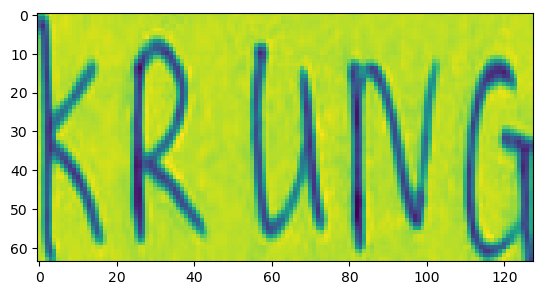

In [13]:
import matplotlib.pyplot as plt
for images,labels,length in train_dataloader:
    images = images.cuda()
    images = images.detach().cpu().numpy()
    images = images[0]
    plt.imshow(images[0])
    label = labels[0]
    print(label[:length[0]])
    label = label.detach().cpu().numpy()
    print(label_decoder([[label]], char_list, length[0]))
    break

## Build Model

In [19]:
pip install torchsummary 

Note: you may need to restart the kernel to use updated packages.


In [20]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torchsummary import summary

class CRNN(nn.Module):
    def __init__(self, num_classes, drop_out_rate = 0.35):
        super().__init__()

        #CNN
        self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding='same', bias=True),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=(2,2))
        )
        self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same', bias=True),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=(2,2))
        )
        self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same', bias=True),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same', bias=True),
        nn.Dropout(drop_out_rate),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,1), stride=(2,1))
        )
        self.conv5 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same', bias=True),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU(),
        )
        self.conv6 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same', bias=True),
        nn.Dropout(drop_out_rate),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,1), stride=(2,1))     
        )   
        self.conv7 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, padding='same', bias=True),
        nn.Dropout(0.25),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU()
        )

        self.fc1 = nn.Sequential(
        nn.Linear(2048, 128),
        nn.ReLU())

        #RNN
        self.rnn1 = nn.LSTM(input_size=128, hidden_size=128, bidirectional=True, batch_first=True) 
        self.rnn2 = nn.LSTM(input_size=256, hidden_size=256, bidirectional=True, batch_first=True)
        #FC
        self.fc2 = nn.Linear(512, num_classes)
        #Softmax
        self.softmax = nn.LogSoftmax(dim=2)
        
        #He/Kaming weight initialization
        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.zeros_(module.bias)

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)        
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        #output of cnn layer has shape (batchsize, channel, height, width)
        
        # input to an LSTM layer in PyTorch has shape (sequence_length, batch_size, input_size) and width should be sq_len (chữ cái thường dễ nhận diện hơn khi chia dọc từng đoạn hơn là chia ngang)
        # CNN to RNN
        x = x.permute(3, 0, 1, 2)
        x = x.reshape(32, 8, -1)
        x = self.fc1(x)

        x = self.rnn1(x)[0]
        x = self.rnn2(x)[0]
        x = self.fc2(x)
        x = self.softmax(x)
        return x
    
if __name__ == '__main__':    
    input_data = torch.rand(8, 1, 64, 128)
    model = CRNN(num_classes=188)
    if torch.cuda.is_available():
        input_data = input_data.cuda()
        model = model.cuda()
    while True:
        result = model(input_data)
        print(result.shape)
        break

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv2d(input, weight, bias, self.stride,


torch.Size([32, 8, 188])


## Train model

In [16]:
pip install mltu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 80.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.4.1
    Uninstalling PyYAML-5.4.1:
      Successfully uninstalled PyYAML-5.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 23.4.1 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
dask-cuda 23.4.0 requires dask==2023.3.2, but you have dask 2023.5.0 which is incompatible.
dask-cudf 23.4.1 requires dask==2023.3.2, but you have dask 2023.5.0 which is incompatible.
distributed 2023.3.2.1 requires dask==2023.3.2, but you have dask 2023.5.0 wh

In [17]:
import os
from datetime import datetime

from mltu.configs import BaseModelConfigs

class ModelConfigs(BaseModelConfigs):
    def __init__(self):
        super().__init__()
        self.trained_models = 'trained_model'
        self.root = '/kaggle/input/handwritten-ocr'
        self.height = 64
        self.width = 128
        self.max_label_len = 16
        self.epochs = 10        
        self.batch_size = 8
        self.learning_rate = 0.001
        self.train_workers = 4
        self.logging = '/kaggle/working/tensorboard'
        self.checkpoint = None

# Add callbacks

## Early Stopping

In [35]:
# class EarlyStopping:
#     def __init__(self, patience=20, min_delta=1e-8, restore_best_weights=True):
#         self.patience = patience
#         self.min_delta = min_delta
#         self.restore_best_weights = restore_best_weights
#         self.counter = 0
#         self.best_loss = None
#         self.early_stop = False

#     def __call__(self, val_loss):
#         if self.best_loss is None:
#             self.best_loss = val_loss
#         elif val_loss < self.best_loss - self.min_delta:
#             self.best_loss = val_loss
#             self.counter = 0
#         else:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 self.early_stop = True

# # # Usage during training loop:
# # early_stopping = EarlyStopping(patience=20, min_delta=1e-8, restore_best_weights=True)
# # if early_stopping(val_loss):
# #     print("Early stopping triggered.")
# #     if early_stopping.restore_best_weights:
# #         # Restore the model to the best state
# #         checkpoint = torch.load('checkpoint.pth')
# #         model.load_state_dict(checkpoint['model_state_dict'])
# #         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


## Validation

In [36]:
# def validation(model, device, valid_loader, loss_function):
#     model.eval()
#     for iter, (images, padded_labels, label_lenghts) in enumerate(val_dataloader):
#             images = images.to(device)
#             padded_labels = padded_labels.to(device)
#             with torch.no_grad():
#                 predictions = model(images)  
#                 loss_value = criterion(predictions, padded_labels, output_lengths, label_lenghts)
#     writer.add_scalar("Val/Loss", loss_value, epoch)
#     checkpoint = {
#         "epoch": epoch + 1,
#         "best_loss" : best_loss,
#         "model": model.state_dict(),
#         "optimizer": optimizer.state_dict()
#     }
#     torch.save(checkpoint, "{}/last_crnn.pt".format(trained_models))

#     if loss_value >= best_loss:
#         torch.save(checkpoint, "{}/best_crnn.pt".format(trained_models))
#         best_loss = loss_value
#     print('Validate', loss_value)



#### Build CER

In [11]:
from mltu.utils.text_utils import get_cer
print(get_cer(['abcde'],['abcde']))
print(get_cer(['abcd2'],['abcde']))
print(get_cer(['abcde','abcd2'],['abcde','abcde']))

0.0
0.2
0.1


**CTC Decoder**

In [ ]:
# train_dataloader = DataLoader(
#         dataset=train_dataset,
#         batch_size=batch_size,
#         num_workers=4,
#         drop_last=True,
#         shuffle=True
#     )

# val_dataloader = DataLoader(
#     dataset=val_dataset,
#     batch_size=batch_size,
#     num_workers=4,
#     drop_last=True,
#     shuffle=True
# )

# # for images,labels,length in train_dataloader:
# #     images = images.cuda()
# #     images = images.detach().cpu().numpy()
# #     images = images[0]
# #     plt.imshow(images[0])
# #     label = labels[0]
# #     print(label[:length[0]])
# #     label = label.detach().cpu().numpy()
# #     print(ctc_decoder([[label]], char_list, length[0]))
# #     break

## Add ReduceLR and Callbacks

In [12]:
# import os
# import torch
# import torch.nn as nn
# from torchvision.transforms import ToTensor, Resize, Compose, RandomAffine, ColorJitter
# from torch.utils.data import DataLoader
# from torch.utils.data import random_split
# import itertools
# import numpy as np
# from argparse import ArgumentParser
# from tqdm.autonotebook import tqdm
# from torch.utils.tensorboard import SummaryWriter
# import shutil
# import warnings
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# warnings.simplefilter("ignore")

# # 2 following functions are used for calculate CER
# def words_from_labels(labels, char_list):
#     """
#     converts the list of encoded integer labels to word strings like eg. [12,10,29] returns CAT 
#     """
#     txt = []
#     for ele in labels:
#         if ele == 0:  # CTC blank space
#             txt.append("")
#         else:
#             txt.append(char_list[ele + 1])
#     return "".join(txt)

# def decode_batch(test_func, word_batch):
#     """
#     Takes the Batch of Predictions and decodes the Predictions by Best Path Decoding and Returns the Output
#     """
#     out = test_func([word_batch])[0]
#     ret = []
#     for j in range(out.shape[0]):
#         out_best = list(np.argmax(out[j, :], 1))
#         out_best = [k for k, g in itertools.groupby(out_best)]
#         outstr = words_from_labels(out_best)
#         ret.append(outstr)
#     return ret

# if __name__ == '__main__':
#     if torch.cuda.is_available():
#         device = torch.device("cuda")
#     else:
#         device = torch.device("cpu")

#     configs = ModelConfigs()
#     root = configs.root
#     num_epochs = configs.epochs
# #     num_epochs = 1

#     batch_size = configs.batch_size
#     max_label_len = configs.max_label_len
#     height = configs.height
#     width = configs.width
#     learning_rate = configs.learning_rate
#     logging = configs.logging
#     trained_models = configs.trained_models
#     checkpoint = configs.checkpoint



#     augment_transform = Compose([RandomAffine(  degrees=(-5, 5),
#                                                 scale=(0.5, 1.05),
#                                                 shear=10),
#                                                 ColorJitter(brightness=0.5,
#                                                             contrast=0.5,
#                                                             saturation=0.5,
#                                                             hue=0.5) ])

# #     if not os.path.isdir(logging):
# #         shutil.rmtree(logging)
# #     if not os.path.isdir(trained_models):
# #         os.mkdir(trained_models)
#     writer = SummaryWriter(logging)

#     char_list = dataset.char_list
#     model = CRNN(num_classes=len(char_list) + 1).to(device)
#     criterion = nn.CTCLoss(blank=0)
#     output_lengths = torch.full(size=(batch_size,), fill_value=max_label_len, dtype=torch.long)
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
#     # Initialize ReduceLROnPlateau scheduler
#     scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
#     # Early stopping 
#     early_stopping = EarlyStopping(patience=20, min_delta=1e-8, restore_best_weights=True)
    
#     best_loss = float('inf')
#     early_stopping_counter = 0
#     early_stopping_patience = 10  # Adjust as needed

#     if checkpoint:
#         checkpoint = torch.load(checkpoint)
#         start_epoch = checkpoint['epoch']
#         best_loss = checkpoint['best_loss']
#         model.load_state_dict(checkpoint["model"])
#         optimizer.load_state_dict(checkpoint["optimizer"])
#     else:
#         start_epoch = 0
#     num_iters = len(train_dataloader)

#     for epoch in range(start_epoch, num_epochs):
#         model.train()
#         progress_bar = tqdm(train_dataloader, colour="green")
#         for iter, (images, padded_labels, label_lenghts) in enumerate(train_dataloader):
#             images = augment_transform(images)
#             images = images.to(device)
#             padded_labels = padded_labels.to(device)
#             outputs = model(images)
#             loss_value = criterion(outputs, padded_labels, output_lengths, label_lenghts)
#             if torch.isinf(loss_value):
#                 print(outputs)
#                 exit()
#             if loss_value != 'lossnan':
#                 progress_bar.set_description("Epoch {}/{}. Iteration {}/{}. Loss{:3f}".format(epoch + 1, num_epochs,
#                                                                                          iter + 1, num_iters, loss_value))
#             else:
#                 break
#             writer.add_scalar("Train/Loss", loss_value, epoch * num_iters + iter)
#             optimizer.zero_grad()
#             loss_value.backward()
#             optimizer.step()

#         model.eval()
#         for iter, (images, padded_labels, label_lenghts) in enumerate(val_dataloader):
#             images = images.to(device)
#             padded_labels = padded_labels.to(device)
#             with torch.no_grad():
#                 predictions = model(images)
#                 loss_value = criterion(predictions, padded_labels, output_lengths, label_lenghts)
#         writer.add_scalar("Val/Loss", loss_value, epoch)
        
#         # Update learning rate scheduler
#         scheduler.step(loss_value)
        
        
#         checkpoint = {
#             "epoch": epoch + 1,
#             "best_loss": best_loss,
#             "model": model.state_dict(),
#             "optimizer": optimizer.state_dict()
#         }
# #         torch.save(checkpoint, "{}/last_crnn.pt".format(trained_models))

# #         if loss_value <= best_loss:
# #             torch.save(checkpoint, "{}/best_crnn.pt".format(trained_models))
# #             best_loss = loss_value
# #         else:
# #             early_stopping_counter += 1
# #             if early_stopping_counter >= early_stopping_patience:
# #                 print("Early stopping triggered.")
# #                 break
                
#         if early_stopping(val_loss):
#             print("Early stopping triggered.")
#         if early_stopping.restore_best_weights:
#             checkpoint = torch.load('checkpoint.pth')
#             model.load_state_dict(checkpoint['model_state_dict'])
#             optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
#         print('Validate', loss_value)


In [4]:
from pytorch_lightning.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=3, verbose=False, mode='auto', strict=True)
# pytorch_lightning.callbacks.early_stopping.EarlyStopping(monitor='val_loss', min_delta=0.0, patience=3, verbose=False, mode='auto', strict=True)

MisconfigurationException: `mode` can be min, max, got auto

In [24]:
pip install pytorchtools

Note: you may need to restart the kernel to use updated packages.


In [29]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [30]:
import os
import torch
import torch.nn as nn
# from OCRDataset import OCRDataset
from torchvision.transforms import ToTensor, Resize, Compose, RandomAffine, ColorJitter
from torch.utils.data import DataLoader
from torch.utils.data import random_split
# from model import CRNN
import itertools
import numpy as np
from argparse import ArgumentParser
# from config import ModelConfigs
from tqdm.autonotebook import tqdm
from torch.utils.tensorboard import SummaryWriter
import shutil
import warnings
warnings.simplefilter("ignore")

if __name__ == '__main__':
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    configs = ModelConfigs()
    root = configs.root
    num_epochs = configs.epochs
    batch_size = configs.batch_size
    train_workers = configs.train_workers
    max_label_len = configs.max_label_len
    height = configs.height
    width = configs.width
    learning_rate = configs.learning_rate
    logging = configs.logging
    trained_models = configs.trained_models
    checkpoint = configs.checkpoint
        
    transform = Compose([
        Resize((height,width)),
        ToTensor(),
         ])
    
    augment_transform= Compose([RandomAffine(
                                            degrees=(-5, 5),
                                            scale=(0.5, 1.05), 
                                            shear=10),
                                ColorJitter(
                                            brightness=0.5, 
                                            contrast=0.5,
                                            saturation=0.5,
                                            hue=0.5)])

    #split train/val dataset
    dataset = OCRDataset(root = root, max_label_len = max_label_len, train=True, transform=transform)

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        num_workers=train_workers,
        drop_last=True,
        shuffle=True
    )

    val_dataloader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        num_workers=train_workers,
        drop_last=True,
        shuffle=True
    )

#     if not os.path.isdir(logging):
#         shutil.rmtree(logging)
#     if not os.path.isdir(trained_models):
#         os.mkdir(trained_models)
    writer = SummaryWriter(logging)

    char_list = dataset.char_list
    model = CRNN(num_classes=len(char_list)+1).to(device)
    criterion = nn.CTCLoss(blank=len(char_list))
    time_steps = max_label_len #time_steps(seq_len) must >= max_label_len but for simplicity, we use time_steps(seq_len) = max_label_len
    output_lengths = torch.full(size=(batch_size,), fill_value=time_steps, dtype=torch.long)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_loss = 0
    if checkpoint:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch']
        best_loss = checkpoint['best_loss']  
        model.load_state_dict(checkpoint["model"])
        optimizer.load_state_dict(checkpoint["optimizer"]) 
    else:
        start_epoch = 0  
    num_iters = len(train_dataloader)
    
    ############
    early_stopping = EarlyStopping(patience=3, verbose=True)
    ############
    
    for epoch in range(start_epoch, num_epochs):
        model.train()
        progress_bar = tqdm(train_dataloader, colour="green")
        sum_loss = 0
        for iter, (images, padded_labels, label_lenghts) in enumerate(train_dataloader):
            images = augment_transform(images)
            images = images.to(device)
            padded_labels = padded_labels.to(device)
            #forward
            optimizer.zero_grad()
            outputs = model(images)
#Shape:     #output(sequence_length, batch_size, num_classes)
            #padded_labels(batch_size, max_label_len)
            #output_lengths, label_lenghts(batch_size)
            loss_value = criterion(outputs, padded_labels, output_lengths, label_lenghts)
            progress_bar.set_description("Epoch {}/{}. Iteration {}/{}. Loss{:3f}".format(epoch+1, num_epochs, iter+1, num_iters, loss_value))
            writer.add_scalar("Train/Loss", loss_value, epoch*num_iters+iter)
            sum_loss += loss_value
            #backward
            loss_value.backward()  
            optimizer.step()
        
        print(' Avg training loss', sum_loss/11587)
        model.eval()

        for iter, (images, padded_labels, label_lenghts) in enumerate(val_dataloader):
            images = images.to(device)
            padded_labels = padded_labels.to(device)
            with torch.no_grad():
                predictions = model(images)  
                loss_value = criterion(predictions, padded_labels, output_lengths, label_lenghts)
        writer.add_scalar("Val/Loss", loss_value, epoch)
        checkpoint = {
            "epoch": epoch + 1,
            "best_loss" : best_loss,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict()
        }
        torch.save(checkpoint, "{}/last_crnn.pt".format(trained_models))

        if loss_value >= best_loss:
            torch.save(checkpoint, "{}/best_crnn.pt".format(trained_models))
            best_loss = loss_value
        print('Validate', loss_value)
        
        ############
        early_stopping(loss_value, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        ############



  0%|          | 0/10300 [00:00<?, ?it/s]

RuntimeError: Expected tensor to have size at least 17 at dimension 1, but got size 16 for argument #2 'targets' (while checking arguments for ctc_loss_gpu)

## Evaluation

In [41]:
import torch
# from model import CRNN
from torch.utils.data import Dataset, DataLoader
# from OCRDataset import OCRDataset
from torchvision.transforms import ToTensor,Compose,Resize
import numpy as np
import itertools

# char_list = OCRDataset(root,32)
# char_list = char_list.char_list

model_path = '/kaggle/input/handwriting/last_crnn (2).pt'
# root = '/kaggle/input/handwritten-ocr'


device = torch.device("cuda")
model = CRNN(num_classes=188).to(device)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model'])

# model.load_state_dict(torch.load(model_path))
# model = torch.jit.load(model_path)
# model.eval()

# train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
# unknown_dataloader = DataLoader(dataset_test, batch_size = batch_size, shuffle=False)

print("Successfully")

Successfully


In [42]:
print(char_list)

['-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'À', 'Á', 'Â', 'Ã', 'È', 'É', 'Ê', 'Ì', 'Í', 'Ò', 'Ó', 'Ô', 'Õ', 'Ù', 'Ú', 'Ý', 'à', 'á', 'â', 'ã', 'è', 'é', 'ê', 'ì', 'í', 'ò', 'ó', 'ô', 'õ', 'ù', 'ú', 'ý', 'Ă', 'ă', 'Đ', 'đ', 'Ĩ', 'ĩ', 'Ũ', 'ũ', 'Ơ', 'ơ', 'Ư', 'ư', 'Ạ', 'ạ', 'Ả', 'ả', 'Ấ', 'ấ', 'Ầ', 'ầ', 'Ẩ', 'ẩ', 'Ẫ', 'ẫ', 'Ậ', 'ậ', 'Ắ', 'ắ', 'Ằ', 'ằ', 'Ẳ', 'ẳ', 'Ẵ', 'ẵ', 'Ặ', 'ặ', 'Ẹ', 'ẹ', 'Ẻ', 'ẻ', 'Ẽ', 'ẽ', 'Ế', 'ế', 'Ề', 'ề', 'Ể', 'ể', 'Ễ', 'ễ', 'Ệ', 'ệ', 'Ỉ', 'ỉ', 'Ị', 'ị', 'Ọ', 'ọ', 'Ỏ', 'ỏ', 'Ố', 'ố', 'Ồ', 'ồ', 'Ổ', 'ổ', 'Ỗ', 'ỗ', 'Ộ', 'ộ', 'Ớ', 'ớ', 'Ờ', 'ờ', 'Ở', 'ở', 'Ỡ', 'ỡ', 'Ợ', 'ợ', 'Ụ', 'ụ', 'Ủ', 'ủ', 'Ứ', 'ứ', 'Ừ', 'ừ', 'Ử', 'ử', 'Ữ', 'ữ', 'Ự', 'ự', 'Ỳ', 'ỳ', 'Ỵ', 'ỵ', 'Ỷ', 'ỷ', 'Ỹ', 'ỹ']


In [43]:
true_labels = []
predict_labels = []
for images,true_label,length in val_dataloader:
    predict_label = model(images.cuda())
#     for label in true_label:
#         true_labels.append(ctc_decoder([[[label]]],char_list, length))
#     for label in predict_label:
#         predict_labels.append(ctc_decoder([[[label]]],char_list, len(label)))
    print(predict_label.shape)
    true_label = true_label[0].cpu().detach().numpy()
    print(label_decoder([[true_label]], char_list))
    break

torch.Size([32, 8, 188])
['song-']


In [44]:
item = predict_label.cpu().permute(1,0,2).detach().numpy()[1]
item.shape

(32, 188)

## CTC_DECODER

In [21]:
import typing
import numpy as np
from itertools import groupby

def ctc_decoder(predictions: np.ndarray, chars: typing.Union[str, list]) -> typing.List[str]:
    """ CTC greedy decoder for predictions
    
    Args:
        predictions (np.ndarray): predictions from model
        chars (typing.Union[str, list]): list of characters

    Returns:
        typing.List[str]: list of words
    """
    # use argmax to find the index of the highest probability
    argmax_preds = np.argmax(predictions, axis=-1)
    
    # use groupby to find continuous same indexes
    grouped_preds = [[k for k,_ in groupby(preds)] for preds in argmax_preds]

    # convert indexes to chars
    texts = ["".join([chars[k] for k in group if k < len(chars)]) for group in grouped_preds]

    return texts

In [28]:
# print(ctc_decoder ([item], char_list))
predict_ = [[-1,-4,-5,-3]]
#             [1,2,4,3],
#             [15,23,2,5],
#             [1,2,3,5],
#             [3,2,1,2]]
char_list_ = ['a','b','c']
print(ctc_decoder ([predict_], char_list_))

['a']


In [50]:
pip install mltu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 55.5 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.4.1
    Uninstalling PyYAML-5.4.1:
      Successfully uninstalled PyYAML-5.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 23.4.1 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
dask-cuda 23.4.0 requires dask==2023.3.2, but you have dask 2023.5.0 which is incompatible.
dask-cudf 23.4.1 requires dask==2023.3.2, but you have dask 2023.5.0 which is incompatible.
distributed 2023.3.2.1 requires dask==2023.3.2, but you have dask 2023.5.0 whi

In [51]:
from mltu.utils.text_utils import get_cer

print(get_cer(['acba'],['acbb']))
# print('CER =', get_cer(true_labels, predict_labels)

0.25


## ANSWER

In [23]:
import typing
import numpy as np
from itertools import groupby

def ctc_decoder(predictions: np.ndarray, chars: typing.Union[str, list]) -> typing.List[str]:
    """ CTC greedy decoder for predictions
    
    Args:
        predictions (np.ndarray): predictions from model
        chars (typing.Union[str, list]): list of characters

    Returns:
        typing.List[str]: list of words
    """
    # use argmax to find the index of the highest probability
    argmax_preds = np.argmax(predictions, axis=-1)
    
    # use groupby to find continuous same indexes
    grouped_preds = [[k for k,_ in groupby(preds)] for preds in argmax_preds]

    # convert indexes to chars
    texts = ["".join([chars[k] for k in group if k < len(chars)]) for group in grouped_preds]

    return texts

# for images in unknown_dataloader:
#     answer_label = model(images.cuda())
#     print
#     for label in answer_label:
#         pass
#         # Ghi kết quả theo file txt


In [33]:
for images in unknown_dataloader:
    answer_label = model(images.cuda())
    print(answer_label)
    print(answer_label.shape)

    for label in answer_label:
        pass
    break
        # Ghi kết quả theo file txt

tensor([[[-5.2411, -5.2434, -5.1770,  ..., -5.1891, -5.3275, -5.2373],
         [-5.2478, -5.2503, -5.1757,  ..., -5.1734, -5.3633, -5.2571],
         [-5.2389, -5.2481, -5.1649,  ..., -5.1491, -5.3618, -5.2681],
         ...,
         [-5.1938, -5.2830, -5.1411,  ..., -5.1258, -5.3313, -5.2565],
         [-5.2155, -5.2962, -5.1285,  ..., -5.1439, -5.2962, -5.2570],
         [-5.2271, -5.2893, -5.1445,  ..., -5.1453, -5.2657, -5.2516]],

        [[-5.2254, -5.2567, -5.1640,  ..., -5.1986, -5.3019, -5.2167],
         [-5.2108, -5.2487, -5.1459,  ..., -5.1668, -5.3128, -5.2214],
         [-5.2148, -5.2707, -5.1485,  ..., -5.1461, -5.3086, -5.2627],
         ...,
         [-5.1838, -5.2776, -5.1546,  ..., -5.1623, -5.3171, -5.3044],
         [-5.1919, -5.2791, -5.1618,  ..., -5.1391, -5.3228, -5.2883],
         [-5.1884, -5.2727, -5.1821,  ..., -5.1767, -5.3035, -5.2713]],

        [[-5.2071, -5.2487, -5.1483,  ..., -5.1717, -5.3048, -5.2209],
         [-5.1932, -5.2629, -5.1280,  ..., -5

## TEST

In [45]:
x = 7
for images,true_label,length in val_dataloader:
    
    predict_label = model(images.cuda())
#     for label in true_label:
#         true_labels.append(ctc_decoder([[[label]]],char_list, length))
#     for label in predict_label:
#         predict_labels.append(ctc_decoder([[[label]]],char_list, len(label)))
    print(predict_label.shape)
    true_label = true_label[x].cpu().detach().numpy()
    print(label_decoder([[true_label]], char_list))
    break

torch.Size([32, 8, 188])
['cấu-']


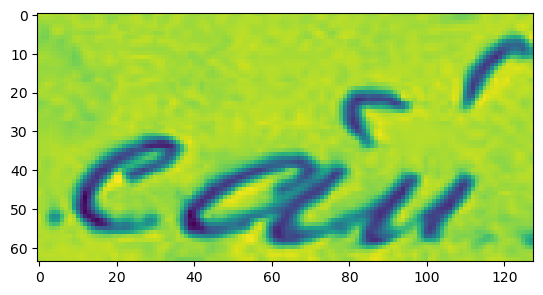

In [46]:
# images
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
# images[0][0].numpy()
plt.imshow(images[x][0].numpy())

In [47]:
item = predict_label.cpu().permute(1,0,2).detach().numpy()[x]
item

array([[-1.62098923e+01, -1.87373161e+01, -1.70370522e+01, ...,
        -2.39031258e+01, -2.08496113e+01, -1.18725402e-04],
       [-1.63031273e+01, -1.66434822e+01, -1.56887217e+01, ...,
        -2.30482693e+01, -2.19659309e+01, -1.14911156e-04],
       [-1.48013391e+01, -1.66760616e+01, -1.62351322e+01, ...,
        -2.38378143e+01, -2.30641956e+01, -3.75502204e-05],
       ...,
       [-1.73581963e+01, -1.84239998e+01, -2.08384323e+01, ...,
        -3.05599003e+01, -2.90801029e+01, -7.03332353e-06],
       [-1.64187336e+01, -1.58503036e+01, -1.74937229e+01, ...,
        -2.79211426e+01, -2.63320599e+01, -3.67157882e-05],
       [-2.33160515e+01, -2.48658638e+01, -2.50479660e+01, ...,
        -3.17328625e+01, -2.71941223e+01,  0.00000000e+00]], dtype=float32)

In [49]:
print(ctc_decoder ([item], char_list))

['cầu']


In [52]:
get_cer([label_decoder([[true_label]], char_list)[0][:-1]],ctc_decoder ([item], char_list))

0.3333333333333333

In [67]:
char_list = dataset.char_list
print(char_list)

['-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'À', 'Á', 'Â', 'Ã', 'È', 'É', 'Ê', 'Ì', 'Í', 'Ò', 'Ó', 'Ô', 'Õ', 'Ù', 'Ú', 'Ý', 'à', 'á', 'â', 'ã', 'è', 'é', 'ê', 'ì', 'í', 'ò', 'ó', 'ô', 'õ', 'ù', 'ú', 'ý', 'Ă', 'ă', 'Đ', 'đ', 'Ĩ', 'ĩ', 'Ũ', 'ũ', 'Ơ', 'ơ', 'Ư', 'ư', 'Ạ', 'ạ', 'Ả', 'ả', 'Ấ', 'ấ', 'Ầ', 'ầ', 'Ẩ', 'ẩ', 'Ẫ', 'ẫ', 'Ậ', 'ậ', 'Ắ', 'ắ', 'Ằ', 'ằ', 'Ẳ', 'ẳ', 'Ẵ', 'ẵ', 'Ặ', 'ặ', 'Ẹ', 'ẹ', 'Ẻ', 'ẻ', 'Ẽ', 'ẽ', 'Ế', 'ế', 'Ề', 'ề', 'Ể', 'ể', 'Ễ', 'ễ', 'Ệ', 'ệ', 'Ỉ', 'ỉ', 'Ị', 'ị', 'Ọ', 'ọ', 'Ỏ', 'ỏ', 'Ố', 'ố', 'Ồ', 'ồ', 'Ổ', 'ổ', 'Ỗ', 'ỗ', 'Ộ', 'ộ', 'Ớ', 'ớ', 'Ờ', 'ờ', 'Ở', 'ở', 'Ỡ', 'ỡ', 'Ợ', 'ợ', 'Ụ', 'ụ', 'Ủ', 'ủ', 'Ứ', 'ứ', 'Ừ', 'ừ', 'Ử', 'ử', 'Ữ', 'ữ', 'Ự', 'ự', 'Ỳ', 'ỳ', 'Ỵ', 'ỵ', 'Ỷ', 'ỷ', 'Ỹ', 'ỹ']
